In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten, MultiHeadAttention, LayerNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Bidirectional, Attention

In [2]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)

    # Match the dimensions of the attention output
    attention_output_dim = attention_output.shape[-1]
    attention_output = Dense(attention_output_dim)(attention_output)

    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward part
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(attention_output_dim)(ffn_output) # Match the dimensions of the attention output
    ffn_output = Dropout(dropout)(ffn_output)
    sequence_output = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

    return sequence_output

In [3]:
data = pd.read_csv('E:/merged_data.csv')
df = data
X = []

Y = []
window_size = 100
for i in range(1, len(df) - window_size - 1, 1):
    first_feature = df.iloc[i, 1]
    second_feature = df.iloc[i, 2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append([(df.iloc[i + j, 1] - first_feature) / first_feature, (df.iloc[i + j, 2] - second_feature) / second_feature])
    temp2.append((df.iloc[i + window_size, 1] - first_feature) / first_feature)
    X.append(np.array(temp).reshape(100, 2))
    Y.append(np.array(temp2).reshape(1, 1))

In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42,shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)

train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,2)
test_X = test_X.reshape(test_X.shape[0],1,100,2)

In [5]:
# Input layer
inputs = Input(shape=(1, 100, 2))

# Model definition
model = tf.keras.Sequential()

# CNN layers
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(inputs)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(128, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(2))(x)
x = TimeDistributed(Flatten())(x)

# Transformer encoder layer
x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=256, dropout=0.1)

# LSTM layers with Attention
x = Bidirectional(LSTM(100, return_sequences=True))(x)
x = Attention()([x, x])
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(100, return_sequences=False))(x)
x = Dropout(0.3)(x)

# Output layer
outputs = Dense(1, activation='linear')(x)

# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [6]:
history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
model.evaluate(test_X, test_Y)

Epoch 1/100
17/17 [==============================] - 16s 192ms/step - loss: 0.5036 - mse: 0.5036 - mae: 0.4466 - val_loss: 0.1389 - val_mse: 0.1389 - val_mae: 0.2866
Epoch 2/100
17/17 [==============================] - 1s 59ms/step - loss: 0.3395 - mse: 0.3395 - mae: 0.3764 - val_loss: 0.1639 - val_mse: 0.1639 - val_mae: 0.2775
Epoch 3/100
17/17 [==============================] - 1s 57ms/step - loss: 0.1818 - mse: 0.1818 - mae: 0.2872 - val_loss: 0.1239 - val_mse: 0.1239 - val_mae: 0.3016
Epoch 4/100
17/17 [==============================] - 1s 57ms/step - loss: 0.1373 - mse: 0.1373 - mae: 0.2670 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1917
Epoch 5/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0980 - mse: 0.0980 - mae: 0.2109 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1705
Epoch 6/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0599 - mse: 0.0599 - mae: 0.1735 - val_loss: 0.0772 - val_mse: 0.0772 - val_mae: 0.1860
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0257 - mse: 0.0257 - mae: 0.0975 - val_loss: 0.0199 - val_mse: 0.0199 - val_mae: 0.1025
Epoch 52/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0952 - val_loss: 0.0137 - val_mse: 0.0137 - val_mae: 0.0876
Epoch 53/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1054 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0852
Epoch 54/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1017 - val_loss: 0.0133 - val_mse: 0.0133 - val_mae: 0.0798
Epoch 55/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0871 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0677
Epoch 56/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0138 - mse: 0.0138 - mae: 0.0805 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0772
Epoch 57/1

5/5 [==============================] - 0s 22ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0705


[0.008588633500039577, 0.008588633500039577, 0.0704868957400322]

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

# Calculate MAE, RMSE, and R^2
mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
print('Mean Absolute Error (MAE): %f' % mae)

rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
print('Root Mean Squared Error (RMSE): %f' % rmse)

r2 = r2_score(test_Y.reshape(-1, 1), yhat_probs)
print('R2 Score: %f' % r2)

Mean Absolute Error (MAE): 0.070487
Root Mean Squared Error (RMSE): 0.092675
R2 Score: 0.991368


In [8]:
# Predict the values using the trained model
predictions = model.predict(test_X)

# Reverse the normalization process
def denormalize(value, first_value):
    return value * first_value + first_value

denormalized_predictions = np.empty_like(predictions)
denormalized_test_Y = np.empty_like(test_Y)

# Apply denormalization
for i in range(len(predictions)):
    first_value = df.iloc[i + window_size, 1]
    denormalized_predictions[i] = denormalize(predictions[i], first_value)
    denormalized_test_Y[i] = denormalize(test_Y[i], first_value)
    
# Compare denormalized predictions with actual values
for i in range(len(denormalized_predictions)):
    print(f"Prediction: {denormalized_predictions[i][0].item():.2f} | Actual: {denormalized_test_Y[i][0].item():.2f}")

5/5 [==============================] - 0s 15ms/step
Prediction: 4496.50 | Actual: 4797.09
Prediction: 6482.20 | Actual: 8005.77
Prediction: 5880.19 | Actual: 5660.46
Prediction: 17250.16 | Actual: 17491.52
Prediction: 14341.03 | Actual: 14316.17
Prediction: 13798.15 | Actual: 14035.62
Prediction: 6723.20 | Actual: 7227.86
Prediction: 16191.93 | Actual: 16488.94
Prediction: 14798.92 | Actual: 13910.74
Prediction: 33614.22 | Actual: 34131.78
Prediction: 5404.21 | Actual: 6202.98
Prediction: 18618.02 | Actual: 19087.91
Prediction: 18495.32 | Actual: 15094.41
Prediction: 18824.07 | Actual: 19819.32
Prediction: 7072.06 | Actual: 8077.90
Prediction: 5888.93 | Actual: 7663.74
Prediction: 4940.29 | Actual: 5407.73
Prediction: 8104.70 | Actual: 7747.14
Prediction: 17938.27 | Actual: 16578.28
Prediction: 19360.85 | Actual: 18306.38
Prediction: 18188.89 | Actual: 16803.64
Prediction: 12236.54 | Actual: 12613.81
Prediction: 26921.49 | Actual: 26242.10
Prediction: 5443.12 | Actual: 5439.01
Predicti

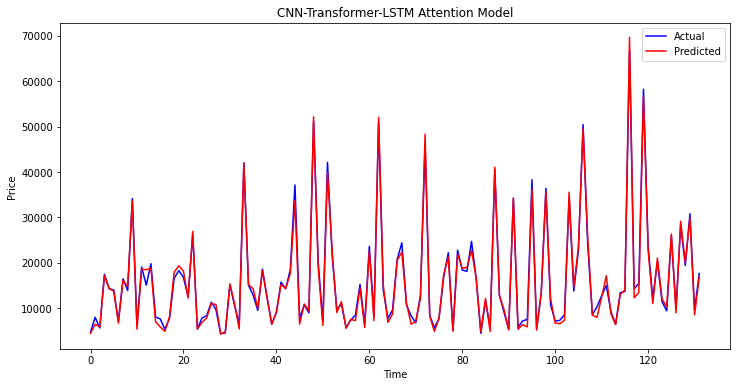

<Figure size 432x288 with 0 Axes>

In [10]:
# Flatten the denormalized_test_Y and denormalized_predictions arrays
denormalized_test_Y_flattened = denormalized_test_Y.flatten()
denormalized_predictions_flattened = denormalized_predictions.flatten()

# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(denormalized_test_Y_flattened, label='Actual', color='blue')
plt.plot(denormalized_predictions_flattened, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('CNN-Transformer-LSTM Attention Model')
plt.show()
# Save the plot as an image file
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')

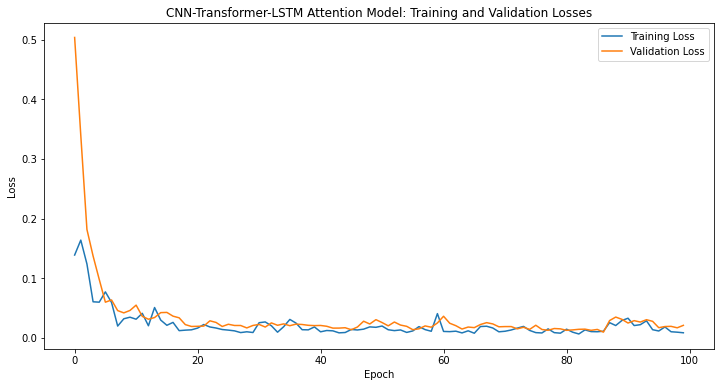

In [11]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Training Loss')
plt.plot(history.history['loss'], label='Validation Loss')
plt.title('CNN-Transformer-LSTM Attention Model: Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
param_grid = {
    'head_size': [64, 128, 256],
    'num_heads': [2, 4, 8],
    'ff_dim': [128, 256, 512]
}

results = []

for head_size in param_grid['head_size']:
    for num_heads in param_grid['num_heads']:
        for ff_dim in param_grid['ff_dim']:
            
            inputs = Input(shape=(1, 100, 2))
            x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(inputs)
            x = TimeDistributed(MaxPooling1D(2))(x)
            x = TimeDistributed(Conv1D(128, kernel_size=5, activation='relu'))(x)
            x = TimeDistributed(MaxPooling1D(2))(x)
            x = TimeDistributed(Conv1D(64, kernel_size=5, activation='relu'))(x)
            x = TimeDistributed(MaxPooling1D(2))(x)
            x = TimeDistributed(Flatten())(x)

            # Transformer encoder layer
            x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=0.1)
            x = Bidirectional(LSTM(100, return_sequences=True))(x)
            x = Attention()([x, x])
            x = Dropout(0.3)(x)
            x = Bidirectional(LSTM(100, return_sequences=False))(x)
            x = Dropout(0.3)(x)

            outputs = Dense(1, activation='linear')(x)
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
            
            model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=100, batch_size=32, verbose=1, shuffle=True)
            
            yhat_probs = model.predict(test_X, verbose=0)
            yhat_probs = yhat_probs[:, 0]

            mae = mean_absolute_error(test_Y.reshape(-1, 1), yhat_probs)
            rmse = np.sqrt(mean_squared_error(test_Y.reshape(-1, 1), yhat_probs))
            
            results.append({
                'head_size': head_size,
                'num_heads': num_heads,
                'ff_dim': ff_dim,
                'MAE': mae,
                'RMSE': rmse
            })

# Convert results to DataFrame for better visualization
df_results = pd.DataFrame(results)
print(df_results)


Epoch 1/100
17/17 [==============================] - 16s 161ms/step - loss: 0.3371 - mse: 0.3371 - mae: 0.3411 - val_loss: 0.1730 - val_mse: 0.1730 - val_mae: 0.2773
Epoch 2/100
17/17 [==============================] - 1s 32ms/step - loss: 0.1271 - mse: 0.1271 - mae: 0.2411 - val_loss: 0.0508 - val_mse: 0.0508 - val_mae: 0.1663
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0942 - mse: 0.0942 - mae: 0.1928 - val_loss: 0.0346 - val_mse: 0.0346 - val_mae: 0.1330
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0455 - mse: 0.0455 - mae: 0.1451 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1011
Epoch 5/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1488 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.1532
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0375 - mse: 0.0375 - mae: 0.1335 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1150
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0718 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0807
Epoch 52/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0135 - mse: 0.0135 - mae: 0.0756 - val_loss: 0.0070 - val_mse: 0.0070 - val_mae: 0.0657
Epoch 53/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0749 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0665
Epoch 54/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0787 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0657
Epoch 55/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0835 - val_loss: 0.0105 - val_mse: 0.0105 - val_mae: 0.0714
Epoch 56/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0707 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0668
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 18s 208ms/step - loss: 0.4182 - mse: 0.4182 - mae: 0.3880 - val_loss: 0.0997 - val_mse: 0.0997 - val_mae: 0.2272
Epoch 2/100
17/17 [==============================] - 1s 34ms/step - loss: 0.1280 - mse: 0.1280 - mae: 0.2490 - val_loss: 0.1470 - val_mse: 0.1470 - val_mae: 0.2501
Epoch 3/100
17/17 [==============================] - 1s 34ms/step - loss: 0.1161 - mse: 0.1161 - mae: 0.2269 - val_loss: 0.0562 - val_mse: 0.0562 - val_mae: 0.1668
Epoch 4/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0643 - mse: 0.0643 - mae: 0.1707 - val_loss: 0.0471 - val_mse: 0.0471 - val_mae: 0.1431
Epoch 5/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0700 - mse: 0.0700 - mae: 0.1646 - val_loss: 0.1040 - val_mse: 0.1040 - val_mae: 0.2260
Epoch 6/100
17/17 [==============================] - 1s 34ms/step - loss: 0.0829 - mse: 0.0829 - mae: 0.1897 - val_loss: 0.1058 - val_mse: 0.1058 - val_mae: 0.2335
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.0938 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0656
Epoch 52/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0796 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0685
Epoch 53/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0747 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0636
Epoch 54/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0169 - mse: 0.0169 - mae: 0.0762 - val_loss: 0.0196 - val_mse: 0.0196 - val_mae: 0.0998
Epoch 55/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0175 - mse: 0.0175 - mae: 0.0838 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0717
Epoch 56/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0789 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0694
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 225ms/step - loss: 0.4537 - mse: 0.4537 - mae: 0.4192 - val_loss: 0.1922 - val_mse: 0.1922 - val_mae: 0.3343
Epoch 2/100
17/17 [==============================] - 1s 43ms/step - loss: 0.2266 - mse: 0.2266 - mae: 0.3131 - val_loss: 0.1554 - val_mse: 0.1554 - val_mae: 0.2509
Epoch 3/100
17/17 [==============================] - 1s 39ms/step - loss: 0.1083 - mse: 0.1083 - mae: 0.2205 - val_loss: 0.0434 - val_mse: 0.0434 - val_mae: 0.1526
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0637 - mse: 0.0637 - mae: 0.1752 - val_loss: 0.0362 - val_mse: 0.0362 - val_mae: 0.1422
Epoch 5/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0564 - mse: 0.0564 - mae: 0.1638 - val_loss: 0.1171 - val_mse: 0.1171 - val_mae: 0.2001
Epoch 6/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0464 - mse: 0.0464 - mae: 0.1465 - val_loss: 0.0310 - val_mse: 0.0310 - val_mae: 0.1407
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0141 - mse: 0.0141 - mae: 0.0745 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0670
Epoch 52/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0666 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0692
Epoch 53/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0748 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0737
Epoch 54/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.0940 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.0977
Epoch 55/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0218 - mse: 0.0218 - mae: 0.0942 - val_loss: 0.0214 - val_mse: 0.0214 - val_mae: 0.1069
Epoch 56/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0800 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0668
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 170ms/step - loss: 0.4072 - mse: 0.4072 - mae: 0.3713 - val_loss: 0.1182 - val_mse: 0.1182 - val_mae: 0.2584
Epoch 2/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0898 - mse: 0.0898 - mae: 0.2100 - val_loss: 0.0704 - val_mse: 0.0704 - val_mae: 0.1924
Epoch 3/100
17/17 [==============================] - 1s 36ms/step - loss: 0.1102 - mse: 0.1102 - mae: 0.2235 - val_loss: 0.0638 - val_mse: 0.0638 - val_mae: 0.1999
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0826 - mse: 0.0826 - mae: 0.2032 - val_loss: 0.0525 - val_mse: 0.0525 - val_mae: 0.1592
Epoch 5/100
17/17 [==============================] - 1s 38ms/step - loss: 0.0685 - mse: 0.0685 - mae: 0.1765 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1122
Epoch 6/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1461 - val_loss: 0.0223 - val_mse: 0.0223 - val_mae: 0.1080
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0781 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0630
Epoch 52/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0760 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0836
Epoch 53/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0762 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0792
Epoch 54/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0137 - mse: 0.0137 - mae: 0.0770 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0908
Epoch 55/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0941 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0818
Epoch 56/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0174 - mse: 0.0174 - mae: 0.0864 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0594
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 177ms/step - loss: 0.4888 - mse: 0.4888 - mae: 0.4346 - val_loss: 0.2897 - val_mse: 0.2897 - val_mae: 0.4235
Epoch 2/100
17/17 [==============================] - 1s 40ms/step - loss: 0.1695 - mse: 0.1695 - mae: 0.3014 - val_loss: 0.0734 - val_mse: 0.0734 - val_mae: 0.1986
Epoch 3/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0850 - mse: 0.0850 - mae: 0.2023 - val_loss: 0.0449 - val_mse: 0.0449 - val_mae: 0.1516
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0605 - mse: 0.0605 - mae: 0.1696 - val_loss: 0.0306 - val_mse: 0.0306 - val_mae: 0.1213
Epoch 5/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0745 - mse: 0.0745 - mae: 0.1845 - val_loss: 0.0838 - val_mse: 0.0838 - val_mae: 0.1793
Epoch 6/100
17/17 [==============================] - 1s 39ms/step - loss: 0.0582 - mse: 0.0582 - mae: 0.1670 - val_loss: 0.0464 - val_mse: 0.0464 - val_mae: 0.1404
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0892 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0684
Epoch 52/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0193 - mse: 0.0193 - mae: 0.0834 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0711
Epoch 53/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0784 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0774
Epoch 54/100
17/17 [==============================] - 1s 44ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0872 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0613
Epoch 55/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0795 - val_loss: 0.0149 - val_mse: 0.0149 - val_mae: 0.0831
Epoch 56/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0835 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0729
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 15s 169ms/step - loss: 0.4597 - mse: 0.4597 - mae: 0.4267 - val_loss: 0.2696 - val_mse: 0.2696 - val_mae: 0.3870
Epoch 2/100
17/17 [==============================] - 1s 45ms/step - loss: 0.1600 - mse: 0.1600 - mae: 0.2706 - val_loss: 0.1042 - val_mse: 0.1042 - val_mae: 0.2408
Epoch 3/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0835 - mse: 0.0835 - mae: 0.1960 - val_loss: 0.0522 - val_mse: 0.0522 - val_mae: 0.1649
Epoch 4/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0822 - mse: 0.0822 - mae: 0.1839 - val_loss: 0.0798 - val_mse: 0.0798 - val_mae: 0.2168
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 0.1070 - mse: 0.1070 - mae: 0.2116 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1292
Epoch 6/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0635 - mse: 0.0635 - mae: 0.1565 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1219
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0943 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0798
Epoch 52/100
17/17 [==============================] - 1s 53ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0853 - val_loss: 0.0164 - val_mse: 0.0164 - val_mae: 0.0920
Epoch 53/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0851 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0662
Epoch 54/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0835 - val_loss: 0.0173 - val_mse: 0.0173 - val_mae: 0.0872
Epoch 55/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0196 - mse: 0.0196 - mae: 0.0882 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0719
Epoch 56/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0226 - mse: 0.0226 - mae: 0.0875 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.0788
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 17s 194ms/step - loss: 0.4198 - mse: 0.4198 - mae: 0.3956 - val_loss: 0.1599 - val_mse: 0.1599 - val_mae: 0.2615
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.1333 - mse: 0.1333 - mae: 0.2579 - val_loss: 0.0776 - val_mse: 0.0776 - val_mae: 0.2172
Epoch 3/100
17/17 [==============================] - 1s 51ms/step - loss: 0.1017 - mse: 0.1017 - mae: 0.2207 - val_loss: 0.0439 - val_mse: 0.0439 - val_mae: 0.1535
Epoch 4/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0799 - mse: 0.0799 - mae: 0.1959 - val_loss: 0.0530 - val_mse: 0.0530 - val_mae: 0.1791
Epoch 5/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0737 - mse: 0.0737 - mae: 0.1924 - val_loss: 0.0417 - val_mse: 0.0417 - val_mae: 0.1499
Epoch 6/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0689 - mse: 0.0689 - mae: 0.1718 - val_loss: 0.0474 - val_mse: 0.0474 - val_mae: 0.1640
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0780 - val_loss: 0.0121 - val_mse: 0.0121 - val_mae: 0.0812
Epoch 52/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.0846 - val_loss: 0.0081 - val_mse: 0.0081 - val_mae: 0.0711
Epoch 53/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0181 - mse: 0.0181 - mae: 0.0841 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0666
Epoch 54/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0817 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0676
Epoch 55/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0797 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0713
Epoch 56/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.0865 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0923
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 15s 212ms/step - loss: 0.3904 - mse: 0.3904 - mae: 0.4247 - val_loss: 0.1768 - val_mse: 0.1768 - val_mae: 0.2976
Epoch 2/100
17/17 [==============================] - 1s 49ms/step - loss: 0.1192 - mse: 0.1192 - mae: 0.2419 - val_loss: 0.0471 - val_mse: 0.0471 - val_mae: 0.1475
Epoch 3/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0651 - mse: 0.0651 - mae: 0.1750 - val_loss: 0.0614 - val_mse: 0.0614 - val_mae: 0.1710
Epoch 4/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0462 - mse: 0.0462 - mae: 0.1503 - val_loss: 0.1223 - val_mse: 0.1223 - val_mae: 0.2079
Epoch 5/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0753 - mse: 0.0753 - mae: 0.1901 - val_loss: 0.0628 - val_mse: 0.0628 - val_mae: 0.1837
Epoch 6/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0650 - mse: 0.0650 - mae: 0.1731 - val_loss: 0.0938 - val_mse: 0.0938 - val_mae: 0.2168
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0803 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0660
Epoch 52/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0736 - val_loss: 0.0162 - val_mse: 0.0162 - val_mae: 0.0828
Epoch 53/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0834 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0648
Epoch 54/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0163 - mse: 0.0163 - mae: 0.0799 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0758
Epoch 55/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0809 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0663
Epoch 56/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0751 - val_loss: 0.0125 - val_mse: 0.0125 - val_mae: 0.0777
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 204ms/step - loss: 0.4441 - mse: 0.4441 - mae: 0.4045 - val_loss: 0.1007 - val_mse: 0.1007 - val_mae: 0.2282
Epoch 2/100
17/17 [==============================] - 1s 58ms/step - loss: 0.1929 - mse: 0.1929 - mae: 0.3017 - val_loss: 0.0663 - val_mse: 0.0663 - val_mae: 0.1845
Epoch 3/100
17/17 [==============================] - 1s 59ms/step - loss: 0.1140 - mse: 0.1140 - mae: 0.2382 - val_loss: 0.0993 - val_mse: 0.0993 - val_mae: 0.2350
Epoch 4/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0685 - mse: 0.0685 - mae: 0.1874 - val_loss: 0.0323 - val_mse: 0.0323 - val_mae: 0.1359
Epoch 5/100
17/17 [==============================] - 1s 67ms/step - loss: 0.0608 - mse: 0.0608 - mae: 0.1739 - val_loss: 0.1058 - val_mse: 0.1058 - val_mae: 0.1966
Epoch 6/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0639 - mse: 0.0639 - mae: 0.1663 - val_loss: 0.1726 - val_mse: 0.1726 - val_mae: 0.2558
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0870 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.0946
Epoch 52/100
17/17 [==============================] - 1s 83ms/step - loss: 0.0176 - mse: 0.0176 - mae: 0.0894 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0680
Epoch 53/100
17/17 [==============================] - 2s 91ms/step - loss: 0.0203 - mse: 0.0203 - mae: 0.0881 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0908
Epoch 54/100
17/17 [==============================] - 2s 89ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0822 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0634
Epoch 55/100
17/17 [==============================] - 1s 75ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0791 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0721
Epoch 56/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0148 - mse: 0.0148 - mae: 0.0796 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0674
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 167ms/step - loss: 0.3703 - mse: 0.3703 - mae: 0.3806 - val_loss: 0.2662 - val_mse: 0.2662 - val_mae: 0.3528
Epoch 2/100
17/17 [==============================] - 1s 46ms/step - loss: 0.1495 - mse: 0.1495 - mae: 0.2697 - val_loss: 0.1468 - val_mse: 0.1468 - val_mae: 0.2811
Epoch 3/100
17/17 [==============================] - 1s 46ms/step - loss: 0.1034 - mse: 0.1034 - mae: 0.2176 - val_loss: 0.0496 - val_mse: 0.0496 - val_mae: 0.1588
Epoch 4/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0473 - mse: 0.0473 - mae: 0.1490 - val_loss: 0.1050 - val_mse: 0.1050 - val_mae: 0.2124
Epoch 5/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0962 - mse: 0.0962 - mae: 0.1875 - val_loss: 0.0942 - val_mse: 0.0942 - val_mae: 0.2061
Epoch 6/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0720 - mse: 0.0720 - mae: 0.1829 - val_loss: 0.0338 - val_mse: 0.0338 - val_mae: 0.1405
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0133 - mse: 0.0133 - mae: 0.0742 - val_loss: 0.0225 - val_mse: 0.0225 - val_mae: 0.1007
Epoch 52/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0264 - mse: 0.0264 - mae: 0.0960 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0970
Epoch 53/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0853 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0863
Epoch 54/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0794 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0717
Epoch 55/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0755 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0689
Epoch 56/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0761 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0970
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 183ms/step - loss: 0.3517 - mse: 0.3517 - mae: 0.3727 - val_loss: 0.1654 - val_mse: 0.1654 - val_mae: 0.2587
Epoch 2/100
17/17 [==============================] - 1s 43ms/step - loss: 0.1175 - mse: 0.1175 - mae: 0.2373 - val_loss: 0.0827 - val_mse: 0.0827 - val_mae: 0.1949
Epoch 3/100
17/17 [==============================] - 1s 43ms/step - loss: 0.1599 - mse: 0.1599 - mae: 0.2670 - val_loss: 0.1162 - val_mse: 0.1162 - val_mae: 0.2472
Epoch 4/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0898 - mse: 0.0898 - mae: 0.2050 - val_loss: 0.0401 - val_mse: 0.0401 - val_mae: 0.1380
Epoch 5/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0699 - mse: 0.0699 - mae: 0.1794 - val_loss: 0.1108 - val_mse: 0.1108 - val_mae: 0.2302
Epoch 6/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0693 - mse: 0.0693 - mae: 0.1873 - val_loss: 0.0548 - val_mse: 0.0548 - val_mae: 0.1659
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0811 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0637
Epoch 52/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0753 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0675
Epoch 53/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0160 - mse: 0.0160 - mae: 0.0810 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0888
Epoch 54/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0864 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0846
Epoch 55/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0845 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0896
Epoch 56/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.0869 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0640
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 174ms/step - loss: 0.4303 - mse: 0.4303 - mae: 0.4207 - val_loss: 0.1110 - val_mse: 0.1110 - val_mae: 0.2706
Epoch 2/100
17/17 [==============================] - 1s 47ms/step - loss: 0.1564 - mse: 0.1564 - mae: 0.2684 - val_loss: 0.1439 - val_mse: 0.1439 - val_mae: 0.2499
Epoch 3/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0993 - mse: 0.0993 - mae: 0.2114 - val_loss: 0.1120 - val_mse: 0.1120 - val_mae: 0.2100
Epoch 4/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0974 - mse: 0.0974 - mae: 0.2133 - val_loss: 0.0416 - val_mse: 0.0416 - val_mae: 0.1483
Epoch 5/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0596 - mse: 0.0596 - mae: 0.1782 - val_loss: 0.0425 - val_mse: 0.0425 - val_mae: 0.1587
Epoch 6/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.1781 - val_loss: 0.0489 - val_mse: 0.0489 - val_mae: 0.1718
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.0864 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1085
Epoch 52/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.0935 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0707
Epoch 53/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0913 - val_loss: 0.0176 - val_mse: 0.0176 - val_mae: 0.1014
Epoch 54/100
17/17 [==============================] - 1s 54ms/step - loss: 0.0251 - mse: 0.0251 - mae: 0.0956 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0821
Epoch 55/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.0925 - val_loss: 0.0259 - val_mse: 0.0259 - val_mae: 0.1209
Epoch 56/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1119 - val_loss: 0.0155 - val_mse: 0.0155 - val_mae: 0.0992
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 182ms/step - loss: 0.4276 - mse: 0.4276 - mae: 0.4226 - val_loss: 0.1606 - val_mse: 0.1606 - val_mae: 0.2937
Epoch 2/100
17/17 [==============================] - 1s 53ms/step - loss: 0.1379 - mse: 0.1379 - mae: 0.2492 - val_loss: 0.0652 - val_mse: 0.0652 - val_mae: 0.1770
Epoch 3/100
17/17 [==============================] - 1s 58ms/step - loss: 0.1015 - mse: 0.1015 - mae: 0.2121 - val_loss: 0.0546 - val_mse: 0.0546 - val_mae: 0.1717
Epoch 4/100
17/17 [==============================] - 1s 67ms/step - loss: 0.1150 - mse: 0.1150 - mae: 0.2126 - val_loss: 0.2561 - val_mse: 0.2561 - val_mae: 0.3249
Epoch 5/100
17/17 [==============================] - 1s 68ms/step - loss: 0.1062 - mse: 0.1062 - mae: 0.2256 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.1941
Epoch 6/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0565 - mse: 0.0565 - mae: 0.1687 - val_loss: 0.0473 - val_mse: 0.0473 - val_mae: 0.1555
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0172 - mse: 0.0172 - mae: 0.0836 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0691
Epoch 52/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0801 - val_loss: 0.0267 - val_mse: 0.0267 - val_mae: 0.0995
Epoch 53/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0220 - mse: 0.0220 - mae: 0.0878 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0730
Epoch 54/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.0891 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0552
Epoch 55/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0831 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0717
Epoch 56/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0796 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.0834
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 15s 201ms/step - loss: 0.3875 - mse: 0.3875 - mae: 0.3878 - val_loss: 0.0830 - val_mse: 0.0830 - val_mae: 0.2059
Epoch 2/100
17/17 [==============================] - 1s 60ms/step - loss: 0.1351 - mse: 0.1351 - mae: 0.2527 - val_loss: 0.0764 - val_mse: 0.0764 - val_mae: 0.1925
Epoch 3/100
17/17 [==============================] - 1s 68ms/step - loss: 0.1273 - mse: 0.1273 - mae: 0.2337 - val_loss: 0.1538 - val_mse: 0.1538 - val_mae: 0.2816
Epoch 4/100
17/17 [==============================] - 1s 63ms/step - loss: 0.1433 - mse: 0.1433 - mae: 0.2599 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1725
Epoch 5/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0954 - mse: 0.0954 - mae: 0.2143 - val_loss: 0.0492 - val_mse: 0.0492 - val_mae: 0.1641
Epoch 6/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0516 - mse: 0.0516 - mae: 0.1608 - val_loss: 0.0257 - val_mse: 0.0257 - val_mae: 0.1116
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0848 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0787
Epoch 52/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0818 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0642
Epoch 53/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.0946 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.1101
Epoch 54/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1008 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0677
Epoch 55/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.0871 - val_loss: 0.0217 - val_mse: 0.0217 - val_mae: 0.0941
Epoch 56/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0244 - mse: 0.0244 - mae: 0.1009 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1040
Epoch 57/1

Epoch 1/100
17/17 [==============================] - 16s 226ms/step - loss: 0.4708 - mse: 0.4708 - mae: 0.4273 - val_loss: 0.1360 - val_mse: 0.1360 - val_mae: 0.2599
Epoch 2/100
17/17 [==============================] - 1s 58ms/step - loss: 0.1615 - mse: 0.1615 - mae: 0.2730 - val_loss: 0.0825 - val_mse: 0.0825 - val_mae: 0.2009
Epoch 3/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0984 - mse: 0.0984 - mae: 0.2120 - val_loss: 0.0434 - val_mse: 0.0434 - val_mae: 0.1475
Epoch 4/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1551 - val_loss: 0.0846 - val_mse: 0.0846 - val_mae: 0.1898
Epoch 5/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0535 - mse: 0.0535 - mae: 0.1682 - val_loss: 0.0674 - val_mse: 0.0674 - val_mae: 0.1759
Epoch 6/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0521 - mse: 0.0521 - mae: 0.1495 - val_loss: 0.0848 - val_mse: 0.0848 - val_mae: 0.1936
Epoch 7/100
17

Epoch 51/100
17/17 [==============================] - 2s 97ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0862 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0647
Epoch 52/100
17/17 [==============================] - 2s 99ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0780 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0783
Epoch 53/100
17/17 [==============================] - 2s 95ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.0941 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.0897
Epoch 54/100
17/17 [==============================] - 2s 95ms/step - loss: 0.0292 - mse: 0.0292 - mae: 0.1016 - val_loss: 0.0132 - val_mse: 0.0132 - val_mae: 0.0860
Epoch 55/100
17/17 [==============================] - 2s 89ms/step - loss: 0.0230 - mse: 0.0230 - mae: 0.0975 - val_loss: 0.0337 - val_mse: 0.0337 - val_mae: 0.1041
Epoch 56/100
17/17 [==============================] - 7s 434ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.0984 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0851
Epoch 57/

17/17 [==============================] - 2s 143ms/step - loss: 0.0134 - mse: 0.0134 - mae: 0.0805 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0717
Epoch 1/100
17/17 [==============================] - 21s 278ms/step - loss: 0.4071 - mse: 0.4071 - mae: 0.4142 - val_loss: 0.0932 - val_mse: 0.0932 - val_mae: 0.2199
Epoch 2/100
17/17 [==============================] - 1s 87ms/step - loss: 0.1529 - mse: 0.1529 - mae: 0.2757 - val_loss: 0.1589 - val_mse: 0.1589 - val_mae: 0.2795
Epoch 3/100
17/17 [==============================] - 2s 101ms/step - loss: 0.2509 - mse: 0.2509 - mae: 0.3041 - val_loss: 0.0786 - val_mse: 0.0786 - val_mae: 0.2063
Epoch 4/100
17/17 [==============================] - 2s 98ms/step - loss: 0.1635 - mse: 0.1635 - mae: 0.2669 - val_loss: 0.0763 - val_mse: 0.0763 - val_mae: 0.2002
Epoch 5/100
17/17 [==============================] - 2s 94ms/step - loss: 0.1127 - mse: 0.1127 - mae: 0.2207 - val_loss: 0.0868 - val_mse: 0.0868 - val_mae: 0.2158
Epoch 6/100
17/17 [=====

Epoch 50/100
17/17 [==============================] - 1s 87ms/step - loss: 0.0177 - mse: 0.0177 - mae: 0.0904 - val_loss: 0.0099 - val_mse: 0.0099 - val_mae: 0.0724
Epoch 51/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0875 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0654
Epoch 52/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0762 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0660
Epoch 53/100
17/17 [==============================] - 1s 89ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.0803 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.0838
Epoch 54/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.1002 - val_loss: 0.0106 - val_mse: 0.0106 - val_mae: 0.0819
Epoch 55/100
17/17 [==============================] - 2s 90ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.0928 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0721
Epoch 56/1

17/17 [==============================] - 2s 109ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0737 - val_loss: 0.0185 - val_mse: 0.0185 - val_mae: 0.0951
Epoch 100/100
17/17 [==============================] - 2s 144ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0899 - val_loss: 0.0160 - val_mse: 0.0160 - val_mae: 0.1019
Epoch 1/100
17/17 [==============================] - 21s 239ms/step - loss: 0.5018 - mse: 0.5018 - mae: 0.4485 - val_loss: 0.1724 - val_mse: 0.1724 - val_mae: 0.2860
Epoch 2/100
17/17 [==============================] - 2s 89ms/step - loss: 0.1745 - mse: 0.1745 - mae: 0.2853 - val_loss: 0.1187 - val_mse: 0.1187 - val_mae: 0.2635
Epoch 3/100
17/17 [==============================] - 2s 91ms/step - loss: 0.1464 - mse: 0.1464 - mae: 0.2397 - val_loss: 0.1210 - val_mse: 0.1210 - val_mae: 0.2468
Epoch 4/100
17/17 [==============================] - 2s 99ms/step - loss: 0.1140 - mse: 0.1140 - mae: 0.2464 - val_loss: 0.0345 - val_mse: 0.0345 - val_mae: 0.1354
Epoch 5/100
17/17 [===

17/17 [==============================] - 2s 104ms/step - loss: 0.0961 - mse: 0.0961 - mae: 0.2167 - val_loss: 0.0278 - val_mse: 0.0278 - val_mae: 0.1322
Epoch 49/100
17/17 [==============================] - 1s 89ms/step - loss: 0.0593 - mse: 0.0593 - mae: 0.1610 - val_loss: 0.0504 - val_mse: 0.0504 - val_mae: 0.1522
Epoch 50/100
17/17 [==============================] - 2s 90ms/step - loss: 0.0575 - mse: 0.0575 - mae: 0.1713 - val_loss: 0.0476 - val_mse: 0.0476 - val_mae: 0.1581
Epoch 51/100
17/17 [==============================] - 1s 86ms/step - loss: 0.0402 - mse: 0.0402 - mae: 0.1442 - val_loss: 0.0248 - val_mse: 0.0248 - val_mae: 0.1221
Epoch 52/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0439 - mse: 0.0439 - mae: 0.1536 - val_loss: 0.0210 - val_mse: 0.0210 - val_mae: 0.1131
Epoch 53/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0277 - mse: 0.0277 - mae: 0.1261 - val_loss: 0.0142 - val_mse: 0.0142 - val_mae: 0.0965
Epoch 54/100
17/17 [==

Epoch 98/100
17/17 [==============================] - 2s 96ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0854 - val_loss: 0.0095 - val_mse: 0.0095 - val_mae: 0.0727
Epoch 99/100
17/17 [==============================] - 2s 97ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0802 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0831
Epoch 100/100
17/17 [==============================] - 2s 123ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.0927 - val_loss: 0.0146 - val_mse: 0.0146 - val_mae: 0.0863
Epoch 1/100
17/17 [==============================] - 18s 211ms/step - loss: 0.5750 - mse: 0.5750 - mae: 0.4873 - val_loss: 0.2854 - val_mse: 0.2854 - val_mae: 0.3859
Epoch 2/100
17/17 [==============================] - 1s 82ms/step - loss: 0.2231 - mse: 0.2231 - mae: 0.3154 - val_loss: 0.1694 - val_mse: 0.1694 - val_mae: 0.2930
Epoch 3/100
17/17 [==============================] - 2s 88ms/step - loss: 0.1651 - mse: 0.1651 - mae: 0.2764 - val_loss: 0.0948 - val_mse: 0.0948 - val_mae: 0.2322
Epoch 4/1

17/17 [==============================] - 2s 96ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0874 - val_loss: 0.0132 - val_mse: 0.0132 - val_mae: 0.0796
Epoch 48/100
17/17 [==============================] - 2s 91ms/step - loss: 0.0191 - mse: 0.0191 - mae: 0.0937 - val_loss: 0.0130 - val_mse: 0.0130 - val_mae: 0.0842
Epoch 49/100
17/17 [==============================] - 2s 95ms/step - loss: 0.0219 - mse: 0.0219 - mae: 0.1027 - val_loss: 0.0122 - val_mse: 0.0122 - val_mae: 0.0849
Epoch 50/100
17/17 [==============================] - 2s 115ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.0951 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0849
Epoch 51/100
17/17 [==============================] - 2s 108ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0900 - val_loss: 0.0179 - val_mse: 0.0179 - val_mae: 0.0927
Epoch 52/100
17/17 [==============================] - 2s 107ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.0957 - val_loss: 0.0186 - val_mse: 0.0186 - val_mae: 0.0888
Epoch 53/100
17/17 [

17/17 [==============================] - 2s 91ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.0904 - val_loss: 0.0235 - val_mse: 0.0235 - val_mae: 0.0972
Epoch 97/100
17/17 [==============================] - 1s 87ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.0932 - val_loss: 0.0197 - val_mse: 0.0197 - val_mae: 0.0982
Epoch 98/100
17/17 [==============================] - 1s 83ms/step - loss: 0.0194 - mse: 0.0194 - mae: 0.0942 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0716
Epoch 99/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0786 - val_loss: 0.0107 - val_mse: 0.0107 - val_mae: 0.0727
Epoch 100/100
17/17 [==============================] - 1s 82ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0794 - val_loss: 0.0205 - val_mse: 0.0205 - val_mae: 0.0898
Epoch 1/100
17/17 [==============================] - 16s 217ms/step - loss: 0.4468 - mse: 0.4468 - mae: 0.4051 - val_loss: 0.0997 - val_mse: 0.0997 - val_mae: 0.2409
Epoch 2/100
17/17 [==

Epoch 46/100
17/17 [==============================] - 1s 75ms/step - loss: 0.0173 - mse: 0.0173 - mae: 0.0847 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0674
Epoch 47/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.0894 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.0954
Epoch 48/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0318 - mse: 0.0318 - mae: 0.1165 - val_loss: 0.0162 - val_mse: 0.0162 - val_mae: 0.0992
Epoch 49/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0248 - mse: 0.0248 - mae: 0.1029 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0781
Epoch 50/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0831 - val_loss: 0.0104 - val_mse: 0.0104 - val_mae: 0.0741
Epoch 51/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0779 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0624
Epoch 52/1

Epoch 96/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0294 - mse: 0.0294 - mae: 0.1213 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0968
Epoch 97/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1266 - val_loss: 0.0218 - val_mse: 0.0218 - val_mae: 0.1075
Epoch 98/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0308 - mse: 0.0308 - mae: 0.1239 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1259
Epoch 99/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0227 - mse: 0.0227 - mae: 0.1079 - val_loss: 0.0240 - val_mse: 0.0240 - val_mae: 0.1257
Epoch 100/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0210 - mse: 0.0210 - mae: 0.1072 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1032
Epoch 1/100
17/17 [==============================] - 16s 183ms/step - loss: 0.4662 - mse: 0.4662 - mae: 0.4379 - val_loss: 0.1690 - val_mse: 0.1690 - val_mae: 0.3153
Epoch 2/

Epoch 46/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.0924 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0875
Epoch 47/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0158 - mse: 0.0158 - mae: 0.0852 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0686
Epoch 48/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.0921 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0677
Epoch 49/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.0901 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0858
Epoch 50/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0204 - mse: 0.0204 - mae: 0.0931 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0827
Epoch 51/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0887 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0750
Epoch 52/1

Epoch 96/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.0919 - val_loss: 0.0148 - val_mse: 0.0148 - val_mae: 0.0870
Epoch 97/100
17/17 [==============================] - 1s 67ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.1021 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.1002
Epoch 98/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.0968 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0801
Epoch 99/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0203 - mse: 0.0203 - mae: 0.0987 - val_loss: 0.0162 - val_mse: 0.0162 - val_mae: 0.0919
Epoch 100/100
17/17 [==============================] - 1s 67ms/step - loss: 0.0199 - mse: 0.0199 - mae: 0.1019 - val_loss: 0.0131 - val_mse: 0.0131 - val_mae: 0.0794
Epoch 1/100
17/17 [==============================] - 16s 203ms/step - loss: 0.4475 - mse: 0.4475 - mae: 0.4318 - val_loss: 0.6687 - val_mse: 0.6687 - val_mae: 0.4893
Epoch 2/

Epoch 46/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0848 - val_loss: 0.0213 - val_mse: 0.0213 - val_mae: 0.1048
Epoch 47/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.0889 - val_loss: 0.0090 - val_mse: 0.0090 - val_mae: 0.0712
Epoch 48/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.0978 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0921
Epoch 49/100
17/17 [==============================] - 1s 73ms/step - loss: 0.0269 - mse: 0.0269 - mae: 0.1029 - val_loss: 0.0266 - val_mse: 0.0266 - val_mae: 0.0992
Epoch 50/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1030 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.0998
Epoch 51/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.0989 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0956
Epoch 52/1

Epoch 96/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0912 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0889
Epoch 97/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0206 - mse: 0.0206 - mae: 0.0912 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0759
Epoch 98/100
17/17 [==============================] - 1s 72ms/step - loss: 0.0299 - mse: 0.0299 - mae: 0.1265 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1194
Epoch 99/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0235 - mse: 0.0235 - mae: 0.1123 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0836
Epoch 100/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0871 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0757
Epoch 1/100
17/17 [==============================] - 16s 239ms/step - loss: 0.4480 - mse: 0.4480 - mae: 0.4180 - val_loss: 0.1815 - val_mse: 0.1815 - val_mae: 0.2930
Epoch 2/

Epoch 46/100
17/17 [==============================] - 2s 92ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0848 - val_loss: 0.0203 - val_mse: 0.0203 - val_mae: 0.1015
Epoch 47/100
17/17 [==============================] - 2s 93ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0866 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0890
Epoch 48/100
17/17 [==============================] - 2s 99ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0826 - val_loss: 0.0161 - val_mse: 0.0161 - val_mae: 0.0883
Epoch 49/100
17/17 [==============================] - 1s 88ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0934 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.0851
Epoch 50/100
17/17 [==============================] - 2s 107ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.0992 - val_loss: 0.0206 - val_mse: 0.0206 - val_mae: 0.0942
Epoch 51/100
17/17 [==============================] - 2s 96ms/step - loss: 0.0185 - mse: 0.0185 - mae: 0.0847 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0790
Epoch 52/

Epoch 96/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.1046 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1069
Epoch 97/100
17/17 [==============================] - 1s 79ms/step - loss: 0.0222 - mse: 0.0222 - mae: 0.1002 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1045
Epoch 98/100
17/17 [==============================] - 1s 79ms/step - loss: 0.0236 - mse: 0.0236 - mae: 0.1119 - val_loss: 0.0222 - val_mse: 0.0222 - val_mae: 0.1098
Epoch 99/100
17/17 [==============================] - 1s 80ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.1124 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0954
Epoch 100/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.1016 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.1122
Epoch 1/100
17/17 [==============================] - 17s 215ms/step - loss: 0.4386 - mse: 0.4386 - mae: 0.4089 - val_loss: 0.2579 - val_mse: 0.2579 - val_mae: 0.3535
Epoch 2/

Epoch 46/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0786 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0786
Epoch 47/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.0885 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0748
Epoch 48/100
17/17 [==============================] - 1s 83ms/step - loss: 0.0241 - mse: 0.0241 - mae: 0.1009 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0667
Epoch 49/100
17/17 [==============================] - 2s 88ms/step - loss: 0.0188 - mse: 0.0188 - mae: 0.0862 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0596
Epoch 50/100
17/17 [==============================] - 2s 93ms/step - loss: 0.0202 - mse: 0.0202 - mae: 0.0915 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.0987
Epoch 51/100
17/17 [==============================] - 2s 101ms/step - loss: 0.0216 - mse: 0.0216 - mae: 0.0991 - val_loss: 0.0159 - val_mse: 0.0159 - val_mae: 0.1028
Epoch 52/

17/17 [==============================] - 1s 81ms/step - loss: 0.0150 - mse: 0.0150 - mae: 0.0777 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0799
Epoch 96/100
17/17 [==============================] - 1s 82ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0764 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0710
Epoch 97/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0120 - mse: 0.0120 - mae: 0.0732 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0625
Epoch 98/100
17/17 [==============================] - 1s 82ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0735 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0601
Epoch 99/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0740 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0805
Epoch 100/100
17/17 [==============================] - 2s 94ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0813 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0672
Epoch 1/100
17/17 [===

17/17 [==============================] - 2s 98ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0908 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.0865
Epoch 45/100
17/17 [==============================] - 2s 122ms/step - loss: 0.0206 - mse: 0.0206 - mae: 0.0900 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0736
Epoch 46/100
17/17 [==============================] - 2s 145ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0873 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0747
Epoch 47/100
17/17 [==============================] - 2s 112ms/step - loss: 0.0154 - mse: 0.0154 - mae: 0.0802 - val_loss: 0.0096 - val_mse: 0.0096 - val_mae: 0.0707
Epoch 48/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0266 - mse: 0.0266 - mae: 0.1037 - val_loss: 0.0252 - val_mse: 0.0252 - val_mae: 0.1114
Epoch 49/100
17/17 [==============================] - 3s 166ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1091 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0710
Epoch 50/100
17/17

17/17 [==============================] - 2s 103ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0683 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0692
Epoch 94/100
17/17 [==============================] - 2s 122ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0673 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0700
Epoch 95/100
17/17 [==============================] - 2s 114ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0744 - val_loss: 0.0101 - val_mse: 0.0101 - val_mae: 0.0737
Epoch 96/100
17/17 [==============================] - 2s 105ms/step - loss: 0.0139 - mse: 0.0139 - mae: 0.0833 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0701
Epoch 97/100
17/17 [==============================] - 2s 107ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0698 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.0849
Epoch 98/100
17/17 [==============================] - 2s 100ms/step - loss: 0.0166 - mse: 0.0166 - mae: 0.0817 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0666
Epoch 99/100
17/1

17/17 [==============================] - 2s 116ms/step - loss: 0.0189 - mse: 0.0189 - mae: 0.0926 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.0921
Epoch 43/100
17/17 [==============================] - 2s 119ms/step - loss: 0.0171 - mse: 0.0171 - mae: 0.0910 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0803
Epoch 44/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0183 - mse: 0.0183 - mae: 0.0907 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0730
Epoch 45/100
17/17 [==============================] - 2s 120ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0902 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0874
Epoch 46/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0215 - mse: 0.0215 - mae: 0.0995 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.1059
Epoch 47/100
17/17 [==============================] - 2s 117ms/step - loss: 0.0179 - mse: 0.0179 - mae: 0.0893 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0640
Epoch 48/100
17/1

17/17 [==============================] - 2s 106ms/step - loss: 0.0159 - mse: 0.0159 - mae: 0.0806 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0833
Epoch 92/100
17/17 [==============================] - 2s 106ms/step - loss: 0.0118 - mse: 0.0118 - mae: 0.0734 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0592
Epoch 93/100
17/17 [==============================] - 2s 111ms/step - loss: 0.0130 - mse: 0.0130 - mae: 0.0709 - val_loss: 0.0094 - val_mse: 0.0094 - val_mae: 0.0669
Epoch 94/100
17/17 [==============================] - 2s 117ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0809 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0748
Epoch 95/100
17/17 [==============================] - 2s 114ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0803 - val_loss: 0.0246 - val_mse: 0.0246 - val_mae: 0.1047
Epoch 96/100
17/17 [==============================] - 2s 117ms/step - loss: 0.0162 - mse: 0.0162 - mae: 0.0823 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0895
Epoch 97/100
17/1

17/17 [==============================] - 2s 106ms/step - loss: 0.0238 - mse: 0.0238 - mae: 0.1071 - val_loss: 0.0107 - val_mse: 0.0107 - val_mae: 0.0778
Epoch 41/100
17/17 [==============================] - 2s 105ms/step - loss: 0.0206 - mse: 0.0206 - mae: 0.0974 - val_loss: 0.0195 - val_mse: 0.0195 - val_mae: 0.1053
Epoch 42/100
17/17 [==============================] - 2s 105ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.0986 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0698
Epoch 43/100
17/17 [==============================] - 2s 108ms/step - loss: 0.0224 - mse: 0.0224 - mae: 0.0990 - val_loss: 0.0125 - val_mse: 0.0125 - val_mae: 0.0784
Epoch 44/100
17/17 [==============================] - 2s 111ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.0881 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0639
Epoch 45/100
17/17 [==============================] - 2s 114ms/step - loss: 0.0151 - mse: 0.0151 - mae: 0.0800 - val_loss: 0.0123 - val_mse: 0.0123 - val_mae: 0.0798
Epoch 46/100
17/1

17/17 [==============================] - 2s 117ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0683 - val_loss: 0.0093 - val_mse: 0.0093 - val_mae: 0.0731
Epoch 90/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0677 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0589
Epoch 91/100
17/17 [==============================] - 2s 114ms/step - loss: 0.0123 - mse: 0.0123 - mae: 0.0727 - val_loss: 0.0064 - val_mse: 0.0064 - val_mae: 0.0607
Epoch 92/100
17/17 [==============================] - 2s 111ms/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0746 - val_loss: 0.0066 - val_mse: 0.0066 - val_mae: 0.0604
Epoch 93/100
17/17 [==============================] - 2s 109ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0687 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0707
Epoch 94/100
17/17 [==============================] - 2s 104ms/step - loss: 0.0112 - mse: 0.0112 - mae: 0.0660 - val_loss: 0.0068 - val_mse: 0.0068 - val_mae: 0.0560
Epoch 95/100
17/1

17/17 [==============================] - 2s 117ms/step - loss: 0.0264 - mse: 0.0264 - mae: 0.1006 - val_loss: 0.0194 - val_mse: 0.0194 - val_mae: 0.0921
Epoch 39/100
17/17 [==============================] - 2s 111ms/step - loss: 0.0207 - mse: 0.0207 - mae: 0.0947 - val_loss: 0.0144 - val_mse: 0.0144 - val_mae: 0.0892
Epoch 40/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0184 - mse: 0.0184 - mae: 0.0895 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0886
Epoch 41/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0267 - mse: 0.0267 - mae: 0.1010 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae: 0.1019
Epoch 42/100
17/17 [==============================] - 2s 113ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.0966 - val_loss: 0.0151 - val_mse: 0.0151 - val_mae: 0.0952
Epoch 43/100
17/17 [==============================] - 2s 116ms/step - loss: 0.0161 - mse: 0.0161 - mae: 0.0872 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0760
Epoch 44/100
17/1

17/17 [==============================] - 2s 119ms/step - loss: 0.0167 - mse: 0.0167 - mae: 0.0834 - val_loss: 0.0091 - val_mse: 0.0091 - val_mae: 0.0693
Epoch 88/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0718 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0844
Epoch 89/100
17/17 [==============================] - 2s 112ms/step - loss: 0.0165 - mse: 0.0165 - mae: 0.0823 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.0942
Epoch 90/100
17/17 [==============================] - 2s 112ms/step - loss: 0.0182 - mse: 0.0182 - mae: 0.0842 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0873
Epoch 91/100
17/17 [==============================] - 2s 110ms/step - loss: 0.0186 - mse: 0.0186 - mae: 0.0922 - val_loss: 0.0100 - val_mse: 0.0100 - val_mae: 0.0789
Epoch 92/100
17/17 [==============================] - 2s 116ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.0817 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.0920
Epoch 93/100
17/1